# Нейросети в обработке текста

Нейросети могут выделить сложные паттерны — взаимоотношения в данных. Для текстов, паттерны проявляются, как именно слова употребляются вместе, как построены фразы. Другими словами, нейросети нужны для того, чтобы представить контекст в виде математического объекта — вектора или матрицы. 

### Основные блоки

1. **Свёрточные блоки** 
  * Для текстов используются одномерные свёртки.
  * Хорошо подходят для нахождения в данных локальных паттернов.
  * Эффективно распараллеливаются на видеокартах 
  * Достаточно быстрые и простые 
  * Хорошо учатся 
  * Недостаточно гибкие и мощные, для широких паттернов — например, сравнивать первое слово в предложении и последнее, игнорируя при этом слова между ними. А также, чтобы увеличить максимальную длину паттерна, нужно существенно увеличить количество параметров свёрточной сети.

2. **Рекуррентные блоки**
  * Последовательно токен за токеном
  * Информация обо всём предложении
  * В результате могут учитываться достаточно длинные зависимости. 
  * Учить гораздо сложнее.

3. **Блоки пулинга**
  * убирает мелкие детали и оставляет только значимые. 
  * соседние элементы матриц усредняются или заменяются на один — например, максимальный.

4. **Блоки внимания**
  * По сути, механизм внимания осуществляет попарное сравнение элементов двух последовательностей, и позволяет выбрать только наиболее значимые их элементы, чтобы продолжить работу только с ними, а всё остальное убрать. 
  * Можно рассматривать механизм внимания как умный адаптивный пулинг. 
  * Сети "с вниманием", как правило, хорошо учатся. 

5. **Рекурсивные нейросети**
  * обобщение RNN
  * работают не с последовательностями, а с деревьями. 
  * Они применяются, например, для того, чтобы сначала выполнить синтаксический анализ, а потом пройтись по построенному дереву и агрегировать информацию из отдельных узлов. 

6. **Графовые свёрточные нейросети**
  * Обобщение и свёрточных, и рекуррентных нейросетей на произвольную структуру графа. 
  * Сейчас активно исследуется.

### Общее описание сверток

Напомню, свертки - это то, с чего начался хайп нейронных сетей в районе 2012-ого.

Работают они примерно так:  
![Conv example](https://image.ibb.co/e6t8ZK/Convolution.gif)   
From [Feature extraction using convolution](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).

Формально - учатся наборы фильтров, каждый из которых скалярно умножается на элементы матрицы признаков. На картинке выше исходная матрица сворачивается с фильтром
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$

Но нужно не забывать, что свертки обычно имеют ещё такую размерность, как число каналов. Например, картинки имеют обычно три канала: RGB.  
Наглядно демонстрируется как выглядят при этом фильтры [здесь](http://cs231n.github.io/convolutional-networks/#conv).

После сверток обычно следуют pooling-слои. Они помогают уменьшить размерность тензора, с которым приходится работать. Самым частым является max-pooling:  
![maxpooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg)  
From [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/#pool)

### Свёртки для текстов

Для текстов свертки работают как n-граммные детекторы (примерно). Каноничный пример символьной сверточной сети:

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)  
From [Character-Aware Neural Language Models](https://arxiv.org/abs/1508.06615)

*Сколько учится фильтров на данном примере?*

На картинке показано, как из слова извлекаются 2, 3 и 4-граммы. Например, желтые - это триграммы. Желтый фильтр прикладывают ко всем триграммам в слове, а потом с помощью global max-pooling извлекают наиболее сильный сигнал.

Что это значит, если конкретнее?

Каждый символ отображается с помощью эмбеддингов в некоторый вектор. А их последовательности - в конкатенации эмбеддингов.  
Например, "abs" $\to [v_a; v_b; v_s] \in \mathbb{R}^{3 d}$, где $d$ - размерность эмбеддинга. Желтый фильтр $f_k$ имеет такую же размерность $3d$.  
Его прикладывание - это скалярное произведение $\left([v_a; v_b; v_s] \odot f_k \right) \in \mathbb R$ (один из желтых квадратиков в feature map для данного фильтра).

Max-pooling выбирает $max_i \left( [v_{i-1}; v_{i}; v_{i+1}] \odot f_k \right)$, где $i$ пробегается по всем индексам слова от 1 до $|w| - 1$ (либо по большему диапазону, если есть padding'и).   
Этот максимум соответствует той триграмме, которая наиболее близка к фильтру по косинусному расстоянию.

В результате в векторе после max-pooling'а закодирована информация о том, какие из n-грамм встретились в слове: если встретилась близкая к нашему $f_k$ триграмма, то в $k$-той позиции вектора будет стоять большое значение, иначе - маленькое.

А учим мы как раз фильтры. То есть сеть должна научиться определять, какие из n-грамм значимы, а какие - нет.

В примере выше мы рассмотрели посимвольное применение свёрток к тексту. Аналогичный подход применим и к токенам на уровне слов. ![text-conv](https://i.ibb.co/pzpLGjD/screen-1.png)
Каждое слово представленно эмбедингом. Свёртки тут выполняют роль биграм.

Какой размер ядра свёртки?

![text-conv2](https://i.ibb.co/wJsDJf1/screen-2.png)

На практике вместо того что бы использовать один фильтр, как правило используют несколько (биграммы, триграммы и тд) каждый из фильтров пораждает своё признаковое описание и даёт несколько больше информации о тексте чем один фильтр. В процессе обучения сети эти фильтры выучиваются и мы можем смотреть на различные взаимосвязи со словами внутри n-gram.

Есть ли проблемы в текущей архитектуре?

Как быть когда мы применили много фильтров и получили несколько выходов?

Эти проблемы решает пулинговый слой.
![text-pool](https://i.ibb.co/J5L1TWx/screen-3.png)
Для текста это max или avg по временной оси. Когда мы берём max-over-time pooling мы обучаем сеть на то что бы она брала максимально информативный фильтр на основе которого можно было бы сделать какие-то выводы. В количестве фильтров мы не ограничены поэтому можно брать большое количество фильтров и пытаться выбирать наиболее информативный фильтр на который обучится сеть.


Типичная схема классификации текста с импользованием свёрток выглядит следующим образом
![text-cls](https://i.ibb.co/N9WyTg0/screen-4.png)
Сначала идут эмбединги слов, затем свёрточные слои, затем Max over time pooling. Причём для задач текста как правило max over time pooling работает лучше чем avg.

Для повышения качества используют много различных свёрток и берётся не один max-pooling, а  K-max это тоже помогает в задачах.
![text-cls2](https://i.ibb.co/2ty181Y/screen-5.png)

Так же как и с изображениями для обработки текста есть глубокие свёрточные архитектуры

![deep-cls](https://i.ibb.co/cTLPPKs/screen-6.png)

Это ResNet подобная архитектура. Сеть довольно мощная и с помощью подобн№ых архитектур сетей можно решать различные задачи, не только классификацию.


# Практика Text classification using CNN

## Задача (Sentiment Analysis)

Собраны твиты 2-ух тональностей, необходимо произвести классификацию на 2-а класса.

In [1]:
max_words = 200
max_len = 40
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [2]:
import pandas as pd

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [3]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [4]:
df_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не полу..."
2,204152,"Хочу лето только ради того, что бы направить н..."
3,204153,RT @RonyLiss: @colf_ne блин((\nа я шипперила Ф...
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое во..."


In [5]:
df_val.head()

,id,text,class
0,181467,RT @TukvaSociopat: Максимальный репост! ))) #є...,1
1,181468,чтоб у меня з.п. ежегодно индексировали на инд...,0
2,181469,@chilyandlime нехуя мне не хорошо !!! :((((,0
3,181470,"@inafish нее , когда ногами ахахах когда?ахаха...",0
4,181471,"Хочу сделать как лучше, а получаю как всегда. :(",0


### Предобработка

In [6]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [7]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [8]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [9]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

/home/rzaharov@mvs.local/.local/share/virtualenvs/nlp-course-A3nIyBIP/lib/python3.8/site-packages/sklearn/datasets/lfw.py:178: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if img.ndim is 0:
[nltk_data] Downloading package punkt to
[nltk_data]     /home/rzaharov@mvs.local/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [10]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [11]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [12]:
tokens_filtered_top[:10]

['rt',
 'd',
 'хотеть',
 'знать',
 'ян',
 'мочь',
 'любить',
 'завтра',
 'мой',
 'хороший']

In [13]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [14]:
import numpy as np
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [15]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["text"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["text"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["text"]], dtype=np.int32)

In [16]:
x_train.shape

(181467, 40)

In [18]:
max_len

40

In [20]:
x_train[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1, 168,
         8], dtype=int32)

# Keras model

In [21]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  

In [22]:
num_classes = 2
y_train = keras.utils.to_categorical(df_train["class"], num_classes)
y_val = keras.utils.to_categorical(df_val["class"], num_classes)

In [23]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len
                   ))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
  1/319 [..............................] - ETA: 0s - loss: 0.6953 - accuracy: 0.4551WARNING:tensorflow:From /home/rzaharov@mvs.local/.local/share/virtualenvs/nlp-course-A3nIyBIP/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
319/319 [==============================] - 69s 215ms/step - loss: 0.6285 - accuracy: 0.6150 - val_loss: 0.6169 - val_accuracy: 0.6219
Epoch 2/20
319/319 [==============================] - 15s 46ms/step - loss: 0.6159 - accuracy: 0.6259 - val_loss: 0.6148 - val_accuracy: 0.6289
Epoch 3/20
319/319 [==============================] - 15s 48ms/step - loss: 0.6121 - accuracy: 0.6304 - val_loss: 0.6129 - val_accuracy: 0.6301
Epoch 4/20
319/319 [==============================] - 13s 42ms/step - loss: 0.6078 - accuracy: 0.6331 - val_loss: 0.6129 - val_accuracy: 0.6232
Ep

In [26]:
score = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 8ms/step - loss: 0.6200 - accuracy: 0.6207


Test score: 0.6200124621391296
Test accuracy: 0.6206851005554199


In [27]:
results = model.predict(x_test, batch_size=batch_size, verbose=1)

45/45 [==============================] - 0s 8ms/step


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score 

In [56]:
vect = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', lowercase=False)

In [57]:
train_ft = vect.fit_transform(df_train['text'])
valid_ft = vect.transform(df_val['text'])

In [58]:
lgr = LogisticRegression()

In [59]:
lgr.fit(train_ft, df_train['class'].to_numpy())

/home/rzaharov@mvs.local/.local/share/virtualenvs/nlp-course-A3nIyBIP/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
y_pred = lgr.predict(valid_ft)

In [61]:
accuracy_score(df_val['class'].to_numpy(), y_pred)

0.7362341841908037

In [160]:
from gensim.models import Word2Vec

In [71]:
df_train['text']

0         alisachachkaн уезжаааааааать ❤ тожена хотеть у...
1         rt galyginvadim ребята девчата кино любовь зав...
2           rt artemklyushin ктоненавидеть пробка ретвит rt
3         rt epupybobv хотеться котлета покиевск запретн...
4         karinekurganova yessboss босапоп есбосан боять...
                                ...                        
181462                     классный новый httptcolejaguxnwu
181463                       видеть человек привет игнорита
181464    julia69styles длинный диагноз вкратце аллергич...
181465    technoslav ух серенький кнопочень телефон дост...
181466    kris1d07 собираться сделатьd навешать фотка ва...
Name: text, Length: 181467, dtype: object

In [72]:
modelW2V = Word2Vec(sentences=df_train['text'].apply(str.split), size=50, window=5, min_count=1)

In [73]:
modelW2V.wv.vocab

{'alisachachkaн': <gensim.models.keyedvectors.Vocab at 0x7f014468cb50>,
 'уезжаааааааать': <gensim.models.keyedvectors.Vocab at 0x7f014468c640>,
 '❤': <gensim.models.keyedvectors.Vocab at 0x7f017c597e20>,
 'тожена': <gensim.models.keyedvectors.Vocab at 0x7f017c5976a0>,
 'хотеть': <gensim.models.keyedvectors.Vocab at 0x7f017c5973a0>,
 'уезжать': <gensim.models.keyedvectors.Vocab at 0x7f017c597e50>,
 'rt': <gensim.models.keyedvectors.Vocab at 0x7f017c597fd0>,
 'galyginvadim': <gensim.models.keyedvectors.Vocab at 0x7f017c597910>,
 'ребята': <gensim.models.keyedvectors.Vocab at 0x7f017c597a30>,
 'девчата': <gensim.models.keyedvectors.Vocab at 0x7f017c5976d0>,
 'кино': <gensim.models.keyedvectors.Vocab at 0x7f01eebe14f0>,
 'любовь': <gensim.models.keyedvectors.Vocab at 0x7f01eebe1790>,
 'завтра': <gensim.models.keyedvectors.Vocab at 0x7f019c2f3190>,
 'вотэтолюбовь': <gensim.models.keyedvectors.Vocab at 0x7f019c2f3a00>,
 'artemklyushin': <gensim.models.keyedvectors.Vocab at 0x7f019c2f34c0>,


In [98]:
vect_idf = TfidfVectorizer()
vect_idf.fit_transform(df_train['text'])
tfidf = dict(zip(vect_idf.get_feature_names(), vect_idf.idf_))

In [156]:
def get_vect_mean(txt):
    vector_w2v = np.zeros(50)
    n_w2v = 0
    for wrd in txt.split():
        if wrd in modelW2V:
            vector_w2v += modelW2V[wrd]
            n_w2v += 1
    if n_w2v > 0:
        vector_w2v = vector_w2v / n_w2v
    return vector_w2v

def get_vect_idf(txt):
    vector_w2v = np.zeros(50)
    n_w2v = 0
    for wrd in txt.split():
        if wrd in modelW2V:
            vector_w2v += modelW2V[wrd]*tfidf.get(wrd, 1.)
            n_w2v += 1
    if n_w2v > 0:
        vector_w2v = vector_w2v / n_w2v
    return vector_w2v

In [139]:
from tqdm import tqdm_notebook

In [140]:
arr_vect = []
for txt in tqdm_notebook(df_train['text']):
    arr_vect.append(get_vect_mean(txt))
    
arr_vect_valid = []
for txt in tqdm_notebook(df_val['text']):
    arr_vect_valid.append(get_vect_mean(txt))
    
train_w2v = np.asarray(arr_vect)    
valid_w2v = np.asarray(arr_vect_valid)

<ipython-input-140-196588226526>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for txt in tqdm_notebook(df_train['text']):


<ipython-input-129-839569e518dd>:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if wrd in modelW2V:
<ipython-input-129-839569e518dd>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector_w2v += modelW2V[wrd]


<ipython-input-140-196588226526>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for txt in tqdm_notebook(df_val['text']):


In [143]:
lgr_w2v = LogisticRegression()

In [144]:
lgr_w2v.fit(train_w2v, df_train['class'].to_numpy())

/home/rzaharov@mvs.local/.local/share/virtualenvs/nlp-course-A3nIyBIP/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [145]:
y_pred = lgr_w2v.predict(valid_w2v)

In [146]:
accuracy_score(df_val['class'].to_numpy(), y_pred)

0.6417140589869065

In [157]:
arr_vect = []
for txt in tqdm_notebook(df_train['text']):
    arr_vect.append(get_vect_idf(txt))
    
arr_vect_valid = []
for txt in tqdm_notebook(df_val['text']):
    arr_vect_valid.append(get_vect_idf(txt))
    
train_w2v = np.asarray(arr_vect)    
valid_w2v = np.asarray(arr_vect_valid)

<ipython-input-157-23a6bf44f63a>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for txt in tqdm_notebook(df_train['text']):


<ipython-input-156-ce09dd437df9>:16: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if wrd in modelW2V:
<ipython-input-156-ce09dd437df9>:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector_w2v += modelW2V[wrd]*tfidf.get(wrd, 1.)


<ipython-input-157-23a6bf44f63a>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for txt in tqdm_notebook(df_val['text']):


In [158]:
lgr_w2v = LogisticRegression()
lgr_w2v.fit(train_w2v, df_train['class'].to_numpy())
y_pred = lgr_w2v.predict(valid_w2v)

/home/rzaharov@mvs.local/.local/share/virtualenvs/nlp-course-A3nIyBIP/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


In [159]:
accuracy_score(df_val['class'].to_numpy(), y_pred)

0.6382312745227704

In [31]:
!tensorboard --logdir logs

2020-09-09 20:05:26.914682: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-09-09 20:05:26.914714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
W0909 20:05:28.516618 140441209849600 plugin_event_accumulator.py:321] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Нейросеть

In [0]:
import random
import torch
import torch.nn as nn

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [0]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [0]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [0]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()

    
train_dataset = DataWrapper(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

Net(
  (embedding): Embedding(20, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Parameters: 52098
Train epoch 1/10
Step 0: loss=0.7216365933418274
Step 100: loss=0.6459038257598877
Train epoch 2/10
Step 0: loss=0.6234788298606873
Step 100: loss=0.6093052625656128
Train epoch 3/10
Step 0: loss=0.6433311700820923
Step 100: loss=0.6456295847892761
Train epoch 4/10
Step 0: loss=0.6052969694137573
Step 100: loss=0.6387022137641907
Train epoch 5/10
Step 0: loss=0.6290259957313538
Step 100: loss=0.6229516267776489
Train epoch 6/10
Step 0: loss=0.6234921216964722
Step 100: loss=0.6081848740577698
Train epoch 7/10
Step 0: loss=0.6184155941009521
Step 100: loss=0.626157283782959
Train epoch 8/10
Step 0: loss=0.6028788685798645
Step 100: loss=0.630898118019104
Train epoch 9/10
Step 0: loss=0.607853889465332
Step 100: loss=0.594542384147644
Train epoch 10/10
Step 0: loss=0.5952185988426208
Step 100: 

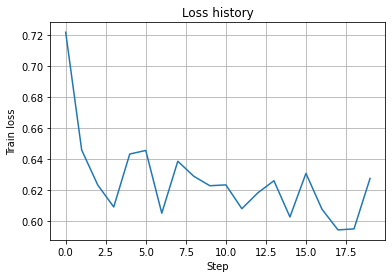

In [0]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);

In [0]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)